In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sys
import json

In [2]:
try:
    # python package (nlp) location - two levels up from this file
    src_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
    # add package to sys.path if it's not already there
    if src_path not in sys.path:
        sys.path.extend([src_path])
except NameError:
    print('issue with adding to path, probably due to __file__ not being defined')
    src_path = None

In [3]:
from nlp.utils import get_database
from nlp import get_configs_path

## Load Data

In [6]:
# get credentials
with open(get_configs_path("mongo.json"), "r+") as f:
    mdb_cred = json.load(f)

# get mongodb client - for connections
client = get_database(username=mdb_cred["username"],
                        password=mdb_cred["password"],
                        clustername=mdb_cred["cluster_name"])

# database names
print(f"database names: {client.list_database_names()}")

prev_fetched = pd.DataFrame(list(client['knowledge_base']["KB"].find(filter={})))

database names: ['new_articles', 'news_articles', 'knowledge_base', 'test', 'admin', 'local']


# Save DB File with 3 Columns Only

In [73]:
#Create a copy with only 3 columns
example_kb_df = prev_fetched.loc[:,['Relationship',"Company Name",'Parent Name']].copy()
#Rename relationship column to make the direction clearer 
example_kb_df.loc[example_kb_df['Relationship'] == "Customer","Relationship"] = "customer of"
example_kb_df.loc[example_kb_df['Relationship'] == "Supplier","Relationship"] = "supplier of"
example_kb_df

,Relationship,Company Name,Parent Name
0,customer of,Apple Inc,Seoul Semiconductor Co Ltd
1,customer of,Koizumi furnitech Thailand Co Ltd,Seoul Semiconductor Co Ltd
2,supplier of,Iri Group Holdings Inc,DS Smith PLC
3,customer of,Amazon.com Inc,DS Smith PLC
4,customer of,Procter & Gamble Co,DS Smith PLC
...,...,...,...
21453,supplier of,SolarWinds Corp,Cisco Systems Inc (Pre-Merger)
21454,supplier of,Unified Communications Ltd,Cisco Systems Inc (Pre-Merger)
21455,customer of,Flexential Colorado Corp,Cisco Systems Inc (Pre-Merger)
21456,supplier of,Verint Systems Inc,Cisco Systems Inc (Pre-Merger)


In [75]:
example_kb_df.to_csv((src_path + "/nlp/data/example_kb.tsv"), sep="\t", index=False, header = False)

In [ ]:
#Use command line to store as gzip file
#In command line: gzip example_kb.tsv

## Descriptive Analysis

In [7]:
#Columns in df
prev_fetched.columns

Index(['_id', 'Parent Name', 'Parent Id', 'Identifier', 'Company Name', 'Type',
       'Relationship', 'Country/Region', 'Industry', 'Confidence Score (%)',
       'Last Update Date', 'Days Since Last Update', 'Freshness',
       'Snippet Count', 'Revenue (USD)', 'EQ Score', 'Implied Rating',
       'fetch_time'],
      dtype='object')

<AxesSubplot:>

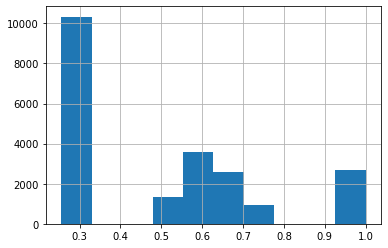

In [40]:
#Distribution of confidence scores
prev_fetched['Confidence Score (%)'].hist()


<AxesSubplot:>

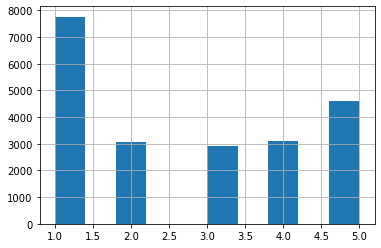

In [41]:
#Distribution of freshness
prev_fetched['Freshness'].hist()


In [44]:
prev_fetched['Freshness'].unique()

array([2, 5, 1, 4, 3])

<AxesSubplot:xlabel='Confidence Score (%)', ylabel='Freshness'>

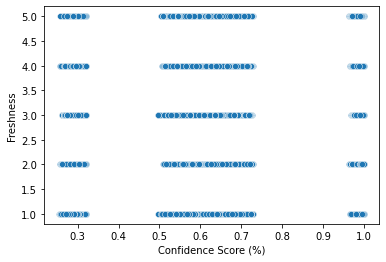

In [47]:
#Freshness vs Confidence in %
sns.scatterplot(data = prev_fetched,x = "Confidence Score (%)", y="Freshness")

In [36]:
#Number of relationships
confidence_threshold = 0.8
prev_fetched_conf = prev_fetched.loc[prev_fetched["Confidence Score (%)"] > confidence_threshold,:]
prev_fetched_conf.shape

(2697, 18)

In [27]:
#Number of parents
num_parents = len(prev_fetched['Parent Name'].unique())
print(num_parents)

572


In [33]:
#Number of relatipnships
num_rel_sup = len(prev_fetched.loc[prev_fetched["Relationship"] == "Supplier",'Parent Name'].unique())
num_rel_cust = len(prev_fetched.loc[prev_fetched["Relationship"] == "Customer",'Parent Name'].unique())
print(num_rel_sup)
print(num_rel_cust)

458
564


In [62]:
#Dates
confidence_threshold = 0.8
yeardf = pd.DataFrame(index = range(2010,2023))
for year in yeardf.index:
    yeardf.loc[year,"Num Articles"] = len(prev_fetched.loc[prev_fetched["Last Update Date"].dt.year.isin([year]) & prev_fetched["Confidence Score (%)"] > confidence_threshold, :])
yeardf



,Num Articles
2010,231.0
2011,604.0
2012,1062.0
2013,1413.0
2014,989.0
2015,905.0
2016,1078.0
2017,2555.0
2018,3014.0
2019,3084.0


# Adapt news file to have long names (Now done in article_analysis)

In [8]:
#Load file with articles and file with short name conversion
articles = pd.read_csv(src_path + "/nlp/data/example_inputs.tsv",sep='\t')
c_count = pd.read_csv(src_path + "/nlp/data/short_name_conversion.tsv",sep='\t')


In [9]:
#function to replace entity short name in articles df with long names from c_count
def replace_entity_name(x,c_count):
    if len(c_count.loc[c_count['short_name']==x,"name"].values) > 0:
        return c_count.loc[c_count['short_name']==x,"name"].values[0]
    elif x == "Lockheed Martin":
        return "Lockheed Martin" 
    else:
        print("{} not matched".format(x))
        return pd.NA
        

In [10]:
#Applying function to the articles df
articles['entity1'] = articles['entity1'].apply(lambda x: replace_entity_name(x,c_count))
articles['entity2'] = articles['entity2'].apply(lambda x: replace_entity_name(x,c_count))
articles.head()

,entity1,entity2,left,middle,right,article
0,Apple Inc,Corning Inc,\n,shares lost {AAPL.O;-PCTCHNG:2} percent as wo...,reported a drop in screen glass sales for the...,620d7165c02377e1232d8ef4
1,Amazon.com Inc,Netflix Inc,"\nOther technology stocks in the FAANG group, ...",and,", also weighed on the Nasdaq.",620d7165c02377e1232d8ef4
2,Corning Inc,Apple Inc,NaN,(GLW.N) on Tuesday reported a drop in sales a...,'s (AAPL.O) iPhone and Samsung's (005930.KS) G...,620d716fc02377e1232d8f11
3,Apple Inc,Corning Inc,\nAt least two other,suppliers - contract chipmaker Taiwan (2330.T...,said net sales in its specialty materials bus...,620d716fc02377e1232d8f11
4,Apple Inc,Taiwan Semiconductor Manufacturing Co Ltd,\nAt least two other,suppliers - contract chipmaker,(2330.TW) and chipmaker AMS (AMS.S) - have po...,620d716fc02377e1232d8f11


In [7]:
articles

,entity1,entity2,left,middle,right,article,label
0,<NA>,Finisar Corp,\nAccording to parts manufacturers,",","and Ams AG, bottlenecks on key parts will mea...",b87f0cf775e9bf0419dd5298dd8339166518f0dd60717b...,0
1,Alphabet Inc,3M Co,* 10-yr yield hits 3 pct for first time in fou...,",",pull indexes down\n*,90ce5e433c2f36e596ecc077cc8d101da1e52fbbfe8f60...,0
2,Alphabet Inc,3M Co,\nTechnology and industrial stocks weighed on ...,", Facebook Inc,",and Caterpillar all falling more than 3.5 per...,90ce5e433c2f36e596ecc077cc8d101da1e52fbbfe8f60...,0
3,3M Co,Alphabet Inc,\nTechnology and industrial stocks weighed on ...,and Caterpillar all falling more than 3.5 per...,"shares fell {GOOGL.O;-PCTCHNG:2}77 percent, e...",90ce5e433c2f36e596ecc077cc8d101da1e52fbbfe8f60...,0
4,Alphabet Inc,3M Co,\n,"shares fell {GOOGL.O;-PCTCHNG:2}77 percent, e...",was the biggest drag on the Dow Jones Industr...,90ce5e433c2f36e596ecc077cc8d101da1e52fbbfe8f60...,0
...,...,...,...,...,...,...,...
23208,Samsung Electronics Co Ltd,Apple Inc,But it is priced cheaper than comparable iPad ...,"Galaxy Tab models at 1,499 yuan (142 pound)) ...","'s iPad,"" Xiaomi's founder Lei Jun said at the...",314f65ec6b5b415077196cf630f4610077090b206a215c...,0
23209,Apple Inc,Samsung Electronics Co Ltd,"\n""Xiaomi has a different business model than",or,","" said Ben Thompson, founder of Stratechery.c...",314f65ec6b5b415077196cf630f4610077090b206a215c...,0
23210,Samsung Electronics Co Ltd,Apple Inc,"\n""Xiaomi has a different business model than ...",","" said Ben Thompson, founder of Stratechery.c...","makes it profits on the hardware, while Xiaom...",314f65ec6b5b415077196cf630f4610077090b206a215c...,0
23211,Sharp Corp,Japan Display Inc,\nXiaomi's success also is creating new opport...,and,", as they bolster their offerings of high-spec...",314f65ec6b5b415077196cf630f4610077090b206a215c...,0


In [91]:
articles.iloc[:,2:-1]


,left,middle,right
0,\n,shares lost {AAPL.O;-PCTCHNG:2} percent as wo...,reported a drop in screen glass sales for the...
1,"\nOther technology stocks in the FAANG group, ...",and,", also weighed on the Nasdaq."
2,NaN,(GLW.N) on Tuesday reported a drop in sales a...,'s (AAPL.O) iPhone and Samsung's (005930.KS) G...
3,\nAt least two other,suppliers - contract chipmaker Taiwan (2330.T...,said net sales in its specialty materials bus...
4,\nAt least two other,suppliers - contract chipmaker,(2330.TW) and chipmaker AMS (AMS.S) - have po...
...,...,...,...
6053,\nProduction from North American shale fields ...,"(SRE.N), Southern Co (SO.N) and",(LNG.A) to look at exports.
6054,LNG developer NextDecade signed up with Projec...,over environmental concerns.\nRENEWABLE NATUR...,"'s Southern California Gas (SoCalGas) unit, Xc..."
6055,\nProduction from North American shale fields ...,", Southern Co and",to look at exports.
6056,\nA U.S. administration official said the prop...,sale was still undergoing interagency review....,and Raytheon declined to comment on the sales.


In [121]:
#Creating a dataframe in the form required by the Coprus class
articles_final = pd.DataFrame()
#Bring DF in shape expected by Corpus class
articles_final.loc[:,["entity1","entity2","left","entity1",'middle','entity2','right',"left","entity1",'middle','entity2','right']] = articles.loc[:,["entity1","entity2","left","entity1",'middle','entity2','right',"left","entity1",'middle','entity2','right']]
#Remove \n as this trips up the Corpus class
articles_final.replace("\n","",inplace=True)
articles_final.replace('(\n)','',regex=True,inplace=True)


In [122]:
#Store as TSV
articles_final.to_csv(src_path + "/nlp/data/example_inputs_long_names.tsv", sep="\t", index=False,header=False)

In [ ]:
import gzip


In [123]:
with open(src_path + "/nlp/data/example_inputs_long_names.tsv", 'rb') as src, gzip.open(src_path + "/nlp/data/example_inputs_long_names.tsv.gz", 'wb') as dst:
    dst.writelines(src)